## Manifold Learning with Cifar10
DSE 12200 HW 5  
Zoya Shafique 


### Dataset Description 
<b> From homework: </b> <br> The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is not that unlike the MNIST data set in that it is is 6K instances of small images. Unlike MNIST they are color images which are 32x32x3 (32 pixels wide, 32 pixels high, 3 color channels). The 3 color channels are red, green and blue. Each pixel is represented by a number between 0 and 255. The data set is divided into 10 classes. The classes are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. The data set is available in the keras.datasets module.

### Algorithms

* Principle Component Analysis
* Isomap Embedding
* Locally Linear Embedding
* Multidimensional scaling.
* SpectralEmbedding
* T-distributed Stochastic Neighbor Embedding


In [17]:
### Importing manifold learning modules from sklearn 
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.decomposition import PCA 
import umap 

### Importing helper packages 
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.keras.datasets import cifar10
import cv2
from cv2 import normalize 

### To supress matlab warnings 
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Dictionary of labels for plotting and looping through data
labels = {0: 'airplane', 1:'automobile', 2:'bird', 3:'cat',
          4:'deer', 5:'dog', 6:'frog',7:'horse',8:'ship',9:'truck'}

(-0.5, 31.5, 31.5, -0.5)

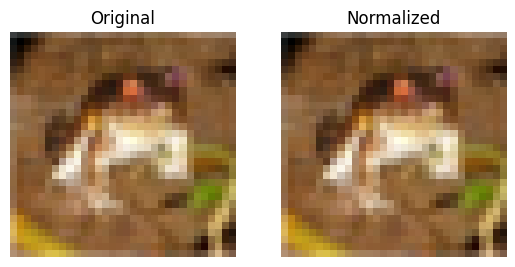

In [62]:
"""
We load the cifar10 dataset using a keras function. As the original dataset has 50,000 samples, processing the entire dataset takes a 
very long time. Therefore we take the first 500 samples for furthur processing. We also scale the data so that all pixels are between 0 and 1.
"""
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train[:500]
X_norm = normalize(X_train.reshape((X_train.shape[0], 3*X_train.shape[1]**2)), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

y_train = y_train[:500].reshape(500,)

# Plotting original and scaled data 
_, ax = plt.subplots(1,2)
ax[0].imshow(X_train[0])
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(X_norm[0].reshape(X_train[0].shape))
ax[1].set_title('Normalized')
ax[1].axis('off')


In [58]:
"""
Setting up the manifold learning functions 
Code based on code from 
"""
n_neighbors = 20  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "random_state": 0,
}

embeddings = {
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "MDS embedding": MDS(
        n_components=2, n_init=1, max_iter=220, n_jobs=2, normalized_stress="auto"
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embeedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "Umap embedding": umap.UMAP(),
}

Text(0.5, 0.98, 'PCA of CIFAR10 dataset')

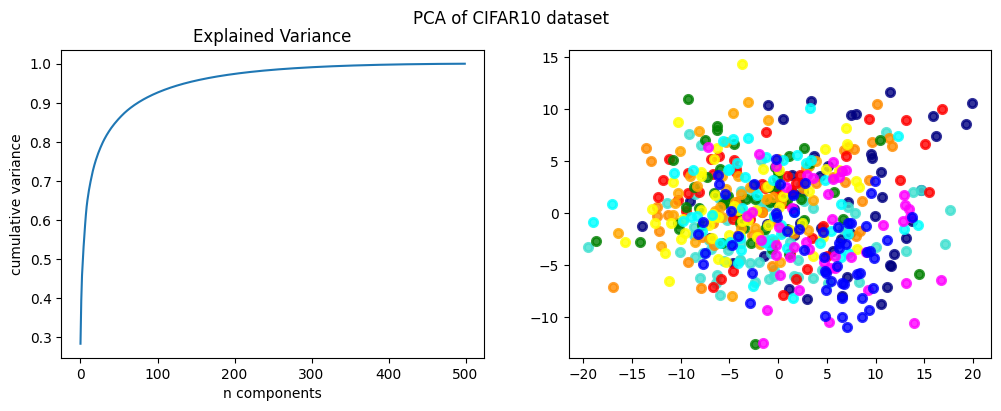

In [63]:
"""
PCA Model 
We fit the PCA model on X_train 
"""
model = PCA()
projection = model.fit_transform(X_norm)

_, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(np.cumsum(model.explained_variance_ratio_))
ax[0].set_xlabel('n components')
ax[0].set_ylabel('cumulative variance')
ax[0].set_title('Explained Variance')


colors = ["navy", "turquoise", "darkorange", 
         'red', 'green', 'orange', 'yellow',
         'cyan', 'magenta', 'blue']
lw = 2
idx = np.arange(0,11,1)

for color, i in zip(colors, labels.keys()):
    ax[1].scatter(
        projection[y_train == i, 0], projection[y_train == i, 1], color=color, alpha=0.8, lw=lw, label=labels[i], 
    )
plt.suptitle("PCA of CIFAR10 dataset")


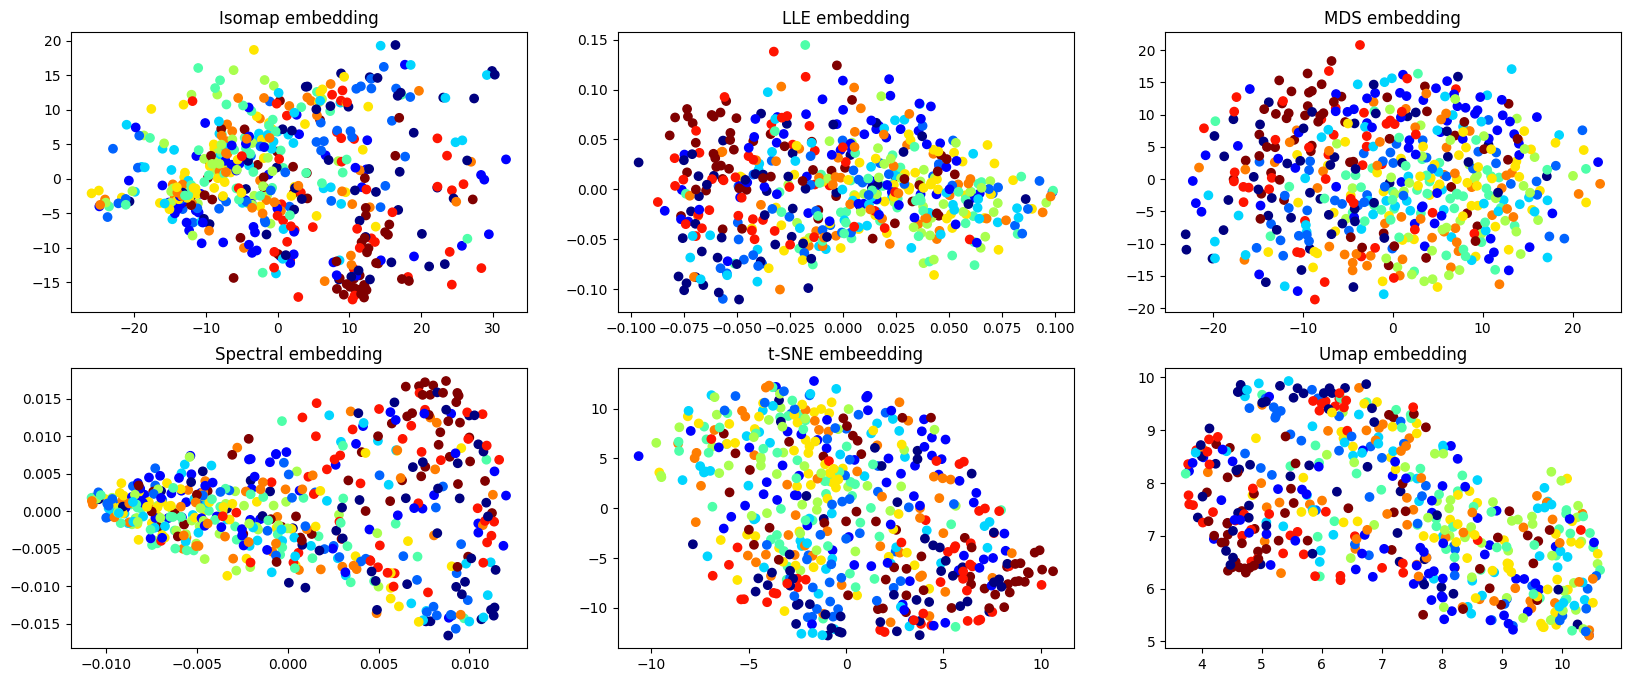

In [64]:
"""
We fit all the manifold models on the train set 
"""

fig, ax = plt.subplots(2,3, figsize=(20,8))
row = 0
i = 0 
for key in embeddings.keys(): 

    transformer = embeddings[key]
    projection = transformer.fit_transform(X_norm)

    if i > 2:
        row = 1
        i = 0

    ax[row][i].scatter(projection[:, 0], projection[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10))
    ax[row][i].set_title(key)
    #plt.colorbar(img, ticks=range(10))
    #plt.clim(-0.5, 9.5)

    i += 1

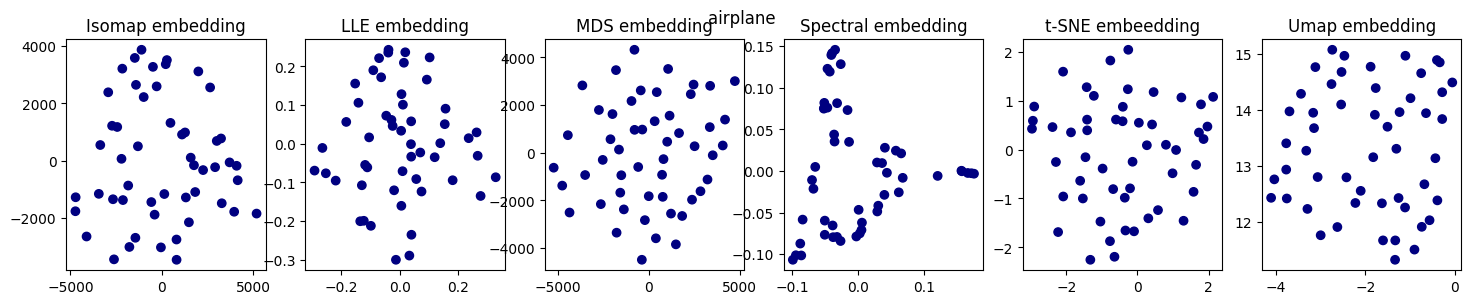

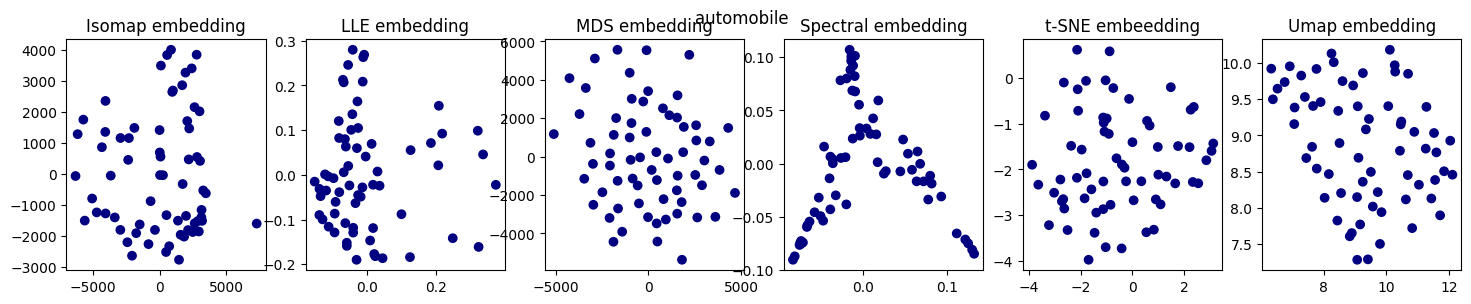

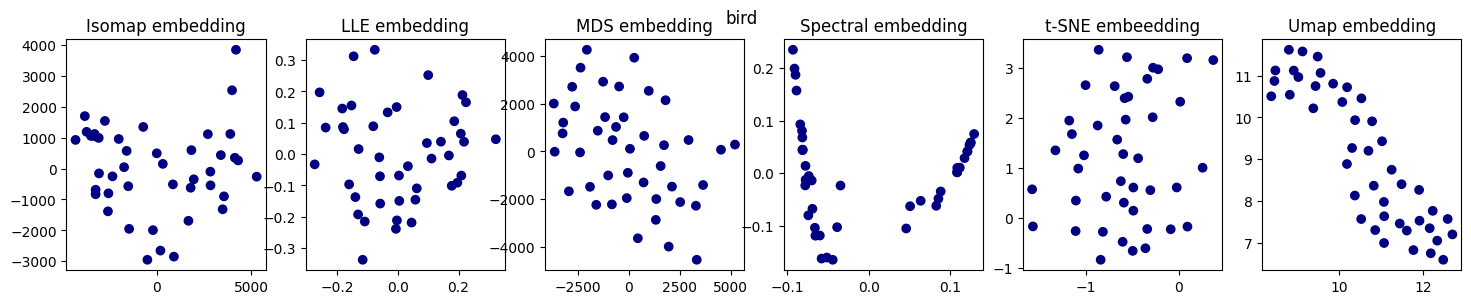

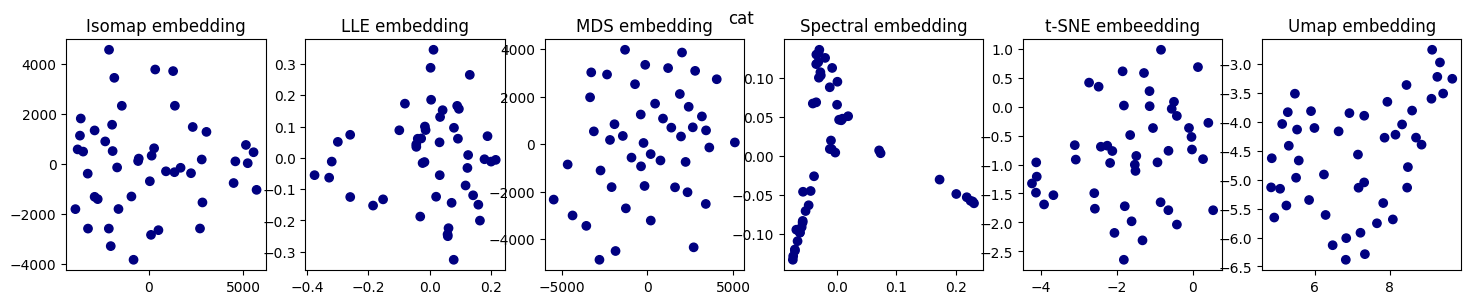

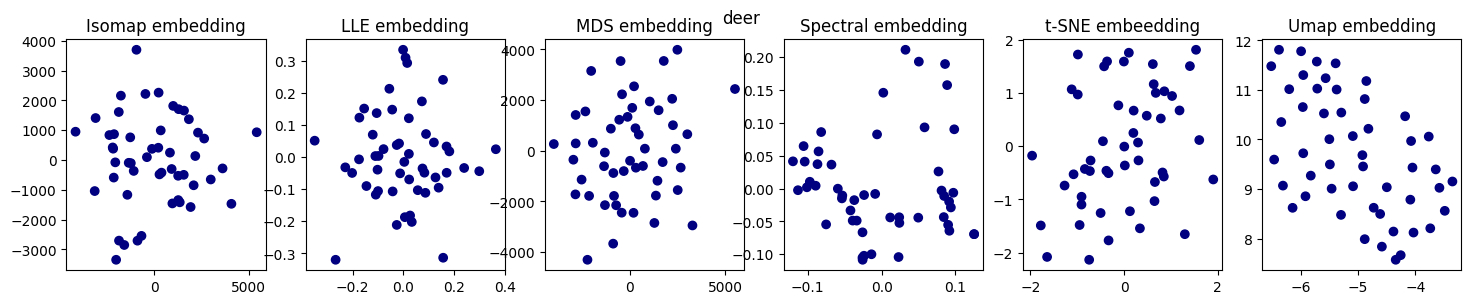

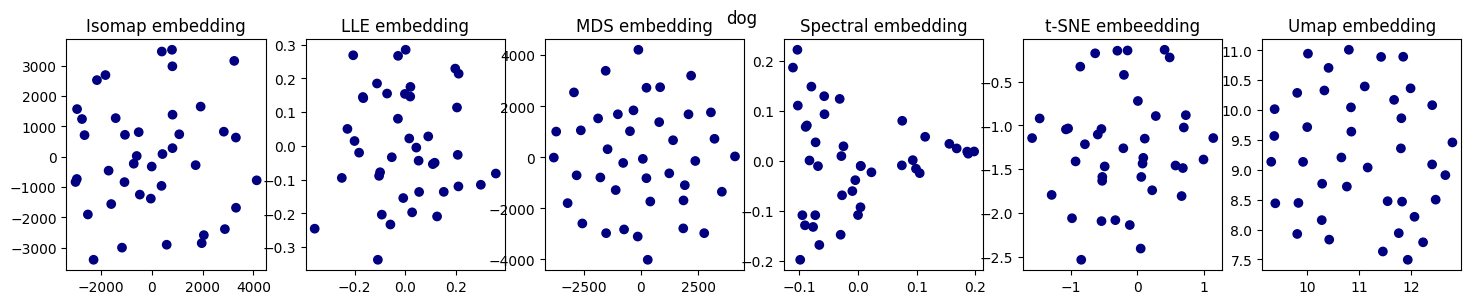

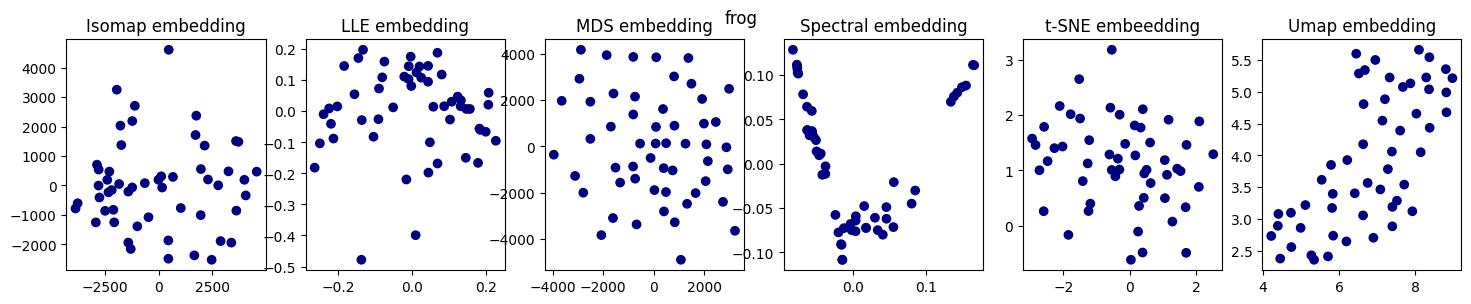

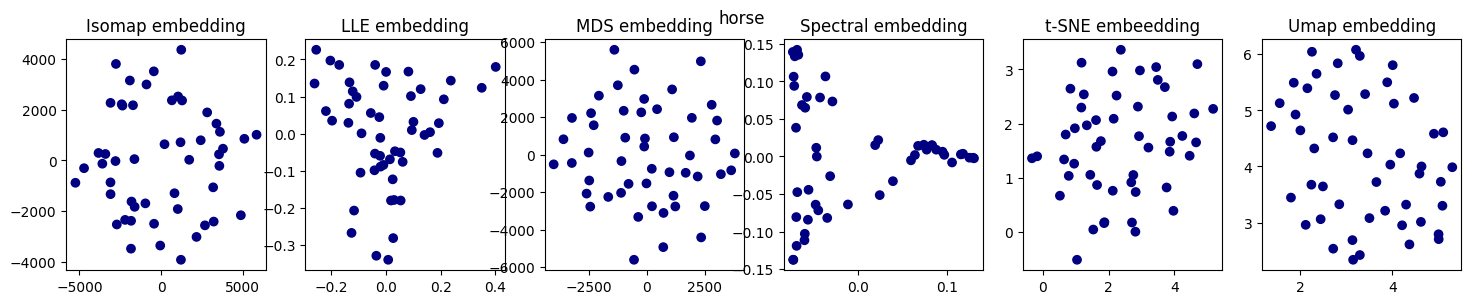

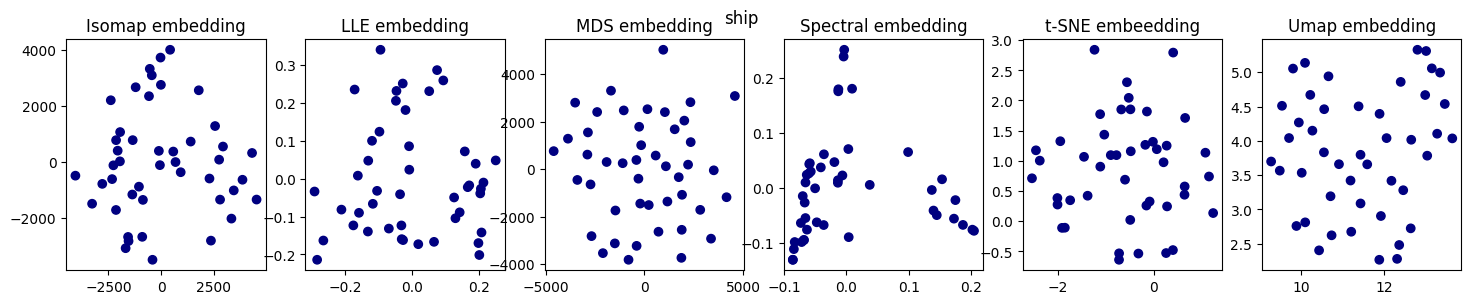

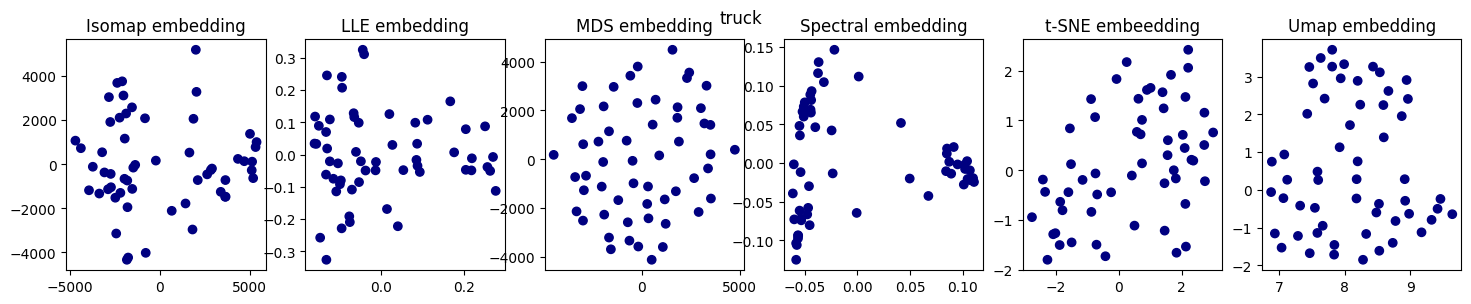

In [28]:
"""
We fit each manifold model to each class in Cifar10
"""

for i in labels.keys(): 

    samples = X_train[y_train == i]
    y_subset = y_train[y_train == i]

    fig, ax = plt.subplots(1,6, figsize=(18,3))
    row = 0
    j = 0 

    for key in embeddings.keys(): 

        transformer = embeddings[key]
        projection = transformer.fit_transform(samples)

        
        ax[j].scatter(projection[:, 0], projection[:, 1], c=y_subset, cmap=plt.cm.get_cmap('jet', 10))
        ax[j].set_title(key)
        plt.suptitle(labels[i])
        #plt.colorbar(img, ticks=range(10))
        #plt.clim(-0.5, 9.5)

        j += 1

### Analyzing TSNE Parameters

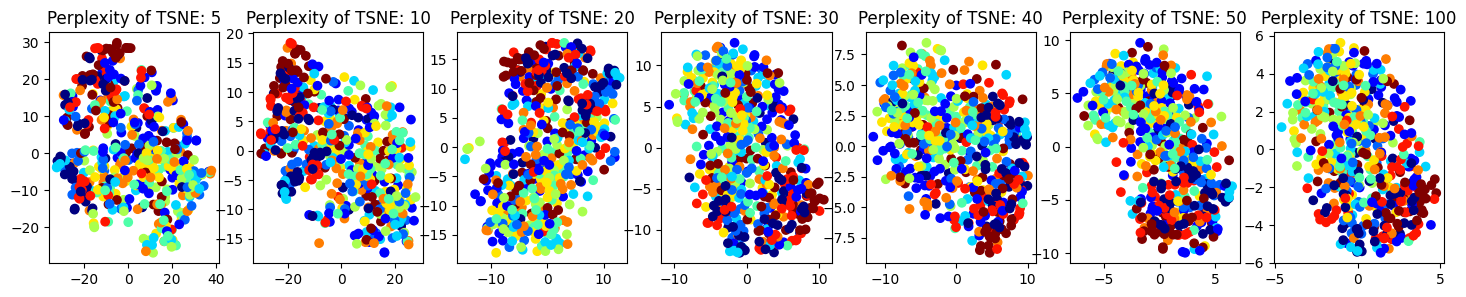

In [65]:

perplexities = [5, 10, 20, 30, 40, 50, 100]
fig, ax = plt.subplots(1, len(perplexities), figsize=(18,3))

for i, val in enumerate(perplexities): 
    tsne = TSNE(
        perplexity = val,
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    )
    projection = tsne.fit_transform(X_norm)

    ax[i].scatter(projection[:, 0], projection[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10))
    ax[i].set_title('Perplexity of TSNE: {}'.format(val))




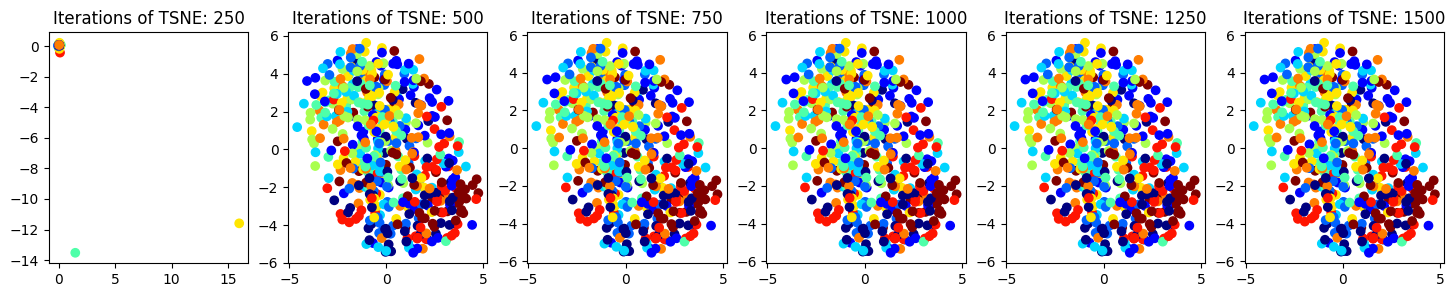

In [66]:

epochs = [250, 500, 750, 1000, 1250, 1500]
fig, ax = plt.subplots(1, len(epochs), figsize=(18,3))

for i, val in enumerate(epochs): 
    tsne = TSNE(
        perplexity = 100,
        n_components=2,
        n_iter=val,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    )

    projection = tsne.fit_transform(X_norm)

    ax[i].scatter(projection[:, 0], projection[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10))
    ax[i].set_title('Iterations of TSNE: {}'.format(val))

### Conclusion

Overall, manifold clustering and PCA analysis do not seem to effectively separate the classes in CIFAR10. Perhaps much more hyperparameter tuning
is required to increase performance 